In [1]:
import time
import os
import mne
import pprint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
import brainflow
from brainflow.board_shim import BrainFlowInputParams, BoardShim
from brainflow.data_filter import DataFilter
import tensorflow as tf

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
# --- Session setup ---

session_class = "right"  # motor imagery class for this session

# main directory
main_dir = os.getcwd()
# eeg data directory
eeg_dir = os.path.join(main_dir, "eeg_data")
# eeg class directory
eeg_class_dir = os.path.join(main_dir, "eeg_data", str(session_class))

# --- EEG headset setup ---

# OpenBCI Cyton board
cyton_board_ID = 0
# serial connection
serial_port = 'COM3'
params = BrainFlowInputParams()
params.serial_port = serial_port
# create board
board = BoardShim(board_id=cyton_board_ID, input_params=params)

# board attributes
board_name = board.get_device_name(board_id=board.board_id)
channel_names = board.get_eeg_names(board_id=board.board_id)
samp_freq = board.get_sampling_rate(board_id=board.board_id)  # 250 Hz
eeg_channel_idx = board.get_eeg_channels(board_id=board.board_id)  # EEG channel indices (1-8)
timestamp_channel = board.get_timestamp_channel(board_id=board.board_id)
num_eeg_channels = len(channel_names)

# --- ML model ---

model_name = "86.67_50-epochs_10-batchsize_1622249278.model"
model_path = os.path.join("models", model_name)
model = tf.keras.models.load_model(model_path)

In [3]:
# --- EEG data acquisition ---
def get_bci_data(num_sec):
    # prepare the board for data stream
    board.prepare_session()
    print("\nSession ready.")
    print("--------------")
    time.sleep(1)
    for i in range(3):
        print(f"Session beginning in {3-i}")
        time.sleep(1)
    # start data stream
    board.start_stream()
    print(f"Recording {num_sec} seconds of data...")

    # number of seconds to record
    time.sleep(num_sec)

    # get all data
    all_data = board.get_board_data() 
    # stop the data stream
    board.stop_stream()
    board.release_session()
    print("Session ended.\n")

    return all_data 

# --- EEG processing ---
def eeg_process(eeg_data, notch=True, hp=True):
    eeg_channel_data = []
    coeff_b, coeff_a = signal.iirnotch(w0=60, Q=30, fs=samp_freq)     # 60 Hz notch filter
    coeff_b2, coeff_a2 = signal.iirnotch(w0=120, Q=30, fs=samp_freq)  # 120 Hz notch filter
    sos = signal.butter(N=4, Wn=0.5, btype="highpass", analog=False, output="sos", fs=samp_freq)  # highpass filter

    for i in range(num_eeg_channels):
        eeg_i = eeg_data[i, :]
        if notch:
            eeg_i = signal.filtfilt(coeff_b, coeff_a, eeg_i)    # notch filter
            eeg_i = signal.filtfilt(coeff_b2, coeff_a2, eeg_i)  # notch filter
        if hp:
            eeg_i = signal.sosfilt(sos, eeg_i)  # highpass filter
        eeg_channel_data.append(eeg_i)

    filtered_eeg = np.asarray(eeg_channel_data)

    return filtered_eeg

# --- Data saving ---
def save_data(dir, all_data, raw_eeg, filtered_eeg):
    # --- Save all data ---
    initial_timestamp = all_data[timestamp_channel, 0]
    filename = str(initial_timestamp) + '_all' + '.txt'
    os.chdir(dir)
    print("\nSaving data in " + str(os.getcwd()))
    DataFilter.write_file(all_data, filename, 'w')
    print("All data saved.")

    # --- Save raw EEG data ---

    filename = str(initial_timestamp) + '_eeg' + '.txt'
    DataFilter.write_file(raw_eeg, filename, 'w')
    print("EEG data saved.")

    # --- Save processed EEG data ---

    filename = str(initial_timestamp) + '_eeg_filtered' + '.txt'
    DataFilter.write_file(filtered_eeg, filename, 'w')
    print("Filtered EEG data saved.")

    os.chdir(main_dir)

def to_one_sec(eeg_data, num_sec=5, samp_freq=250):
    one_sec_data = []
    for i in range(num_sec):
        eeg_data_i = eeg_data[i*samp_freq:(i+1)*samp_freq]
        one_sec_data.append(eeg_data_i)

    return one_sec_data

In [8]:
def main():
    num_sec = 8  # number of seconds to record
    all_data = get_bci_data(num_sec=num_sec)
    raw_eeg = all_data[eeg_channel_idx, 2*samp_freq:(num_sec-1)*samp_freq]  # artifactual eeg data removed, uniform size
    filtered_eeg = eeg_process(eeg_data=raw_eeg, notch=True, hp=False)
    filtered_eegT = np.transpose(filtered_eeg)

    one_sec_list = to_one_sec(eeg_data=filtered_eegT, num_sec=5, samp_freq=samp_freq)
    predict_list = []

    for i in range(len(one_sec_list)):  # for each 1 second trial
        one_sec_data = one_sec_list[i]              # (250, 8) eeg data
        one_sec_dataT = np.transpose(one_sec_data)  # (8, 250) eeg data  
        
        eeg_predict = one_sec_dataT.reshape(1, 8, 250)
        predict_vec = model.predict(eeg_predict)[0]
        predict_list.append(predict_vec)
        #print(predict_vec)

    predict_avgs = [round(sum(x) / len(x) * 100, 2) for x in zip(*predict_list)] 
    #print(predict_avgs)
    left_pred = predict_avgs[0]
    right_pred = predict_avgs[1]
    none_pred = predict_avgs[2]

    print(f"Actual MI class\n---------------\n{session_class.title()}\n")
    print(f"Predicted MI class\n------------------\nLeft:  {left_pred} %\nRight: {right_pred} %\nNone:  {none_pred} %\n")

    df = pd.DataFrame(np.transpose(filtered_eeg))
    df = df/1000  # uV to mV
    df.plot(subplots=True)
    plt.show()
    #plt.savefig('after_processing.png')

    save = str(input("Save recorded data? [y]/[n]\n"))
    if save == "y":
        save_data(dir=eeg_class_dir, all_data=all_data, raw_eeg=raw_eeg, filtered_eeg=filtered_eeg)
    else:
        pass



Session ready.
--------------
Session beginning in 3
Session beginning in 2
Session beginning in 1
Recording 8 seconds of data...
Session ended.

Actual MI class
---------------
Right

Predicted MI class
------------------
Left:  0.0 %
Right: 56.11 %
None:  43.89 %



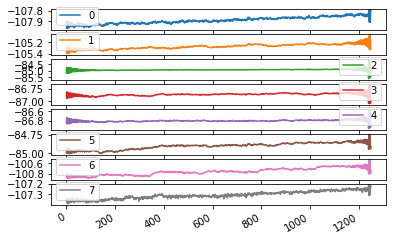

In [9]:
main()